In [1]:
# import all necessary libraries
import sys
import os
from datetime import datetime, timedelta
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import random
from osgeo import gdal
import re
from tqdm import tqdm
import shutil
import calendar
import math
import joblib
import cv2

import rasterio as rio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.shutil import copy
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import Affine
from rasterio.merge import merge

import pyproj
from pyproj import Proj

from shapely.ops import transform
from shapely.geometry import Polygon

import time

from cartopy import crs
# import hvplot.xarray
# import holoviews as hv
# gv.extension('bokeh', 'matplotlib')

from multiprocessing.pool import ThreadPool
import concurrent.futures

In [2]:
%cd /scratch/user/anshulya/
%ls

/scratch/user/anshulya
100/                        data_download_driver.sh*         script_100_2.sh
119/                        estimate_area.py                 script_100_3.sh
124/                        estimate_area_canny.py           script_100_4.sh
134/                        estimate_area_canny_parallel.py  script_119_1.sh
138/                        frequency.png                    script_119_2.sh
158/                        hls_data/                        script_119_3.sh
167/                        hls_job1.sh                      script_119_4.sh
20/                         hls_job2.sh                      script_124_1.sh
212/                        hls_job3.sh                      script_124_2.sh
270/                        hls_job4.sh                      script_124_3.sh
383_LAKE_MEAD.tif           in-situ_data.csv                 script_124_4.sh
49/                         jrc_data/                        script_138_1.sh
800_res.geojson             jupyter_notebooks/       

In [6]:
def preprocess_reservoir_shp(fname):
  reservoirs = gp.read_file(fname)

  reservoirs.loc[107,'name'] = 'Farmer_s Creek Reservoir'

  t = ['/' in s for s in reservoirs['name']]
  i = 0
  res_names = ['Cox Lake', 'Eagle Nest Lake_Manor Lake', 'Lake Ballinger_Lake Moonen', 'Lake Olney_Lake Cooper', 'Mustang Lake']
  for res_idx in [77, 93, 183, 249, 313]:
    reservoirs.loc[res_idx, 'name'] = res_names[i]
    i = i + 1

  i = 0
  res_names = ['Lake Gonzales','Clear Lake Wa']
  for res_idx in [218, 70]:
    reservoirs.loc[res_idx, 'name'] = res_names[i]
    i = i + 1

  for i in range(809):
    string = reservoirs.loc[i, 'name']
    regex = re.compile('[@!#$%^&*()<>?/\|}{~]')
    # Pass the string in search
    # method of regex object.
    if(regex.search(string) == None):
      continue
    else:
      print(i,string)

  return reservoirs

In [7]:
## Get reservoir shapefile and geometry
fname = '800_res.geojson'
reservoirs = preprocess_reservoir_shp(fname)

100%|██████████| 1163/1163 [13:02<00:00,  1.49it/s]


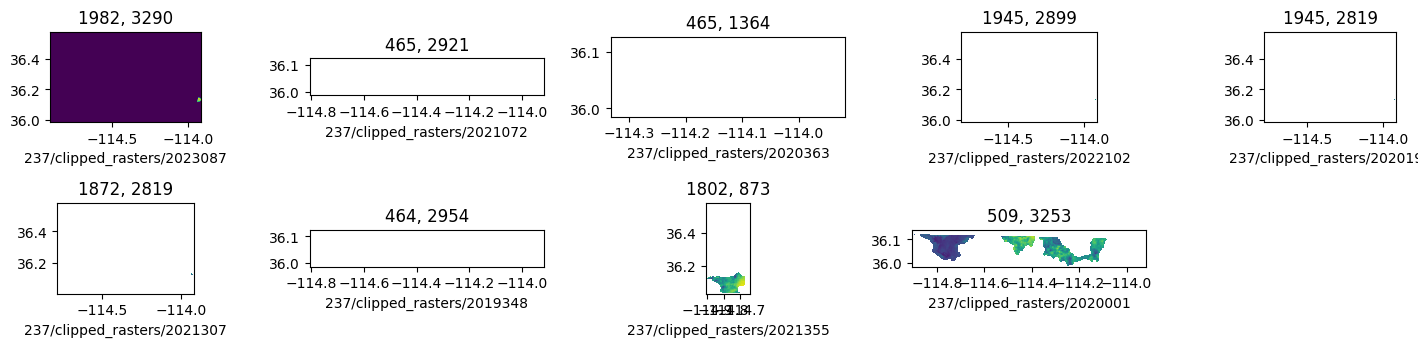

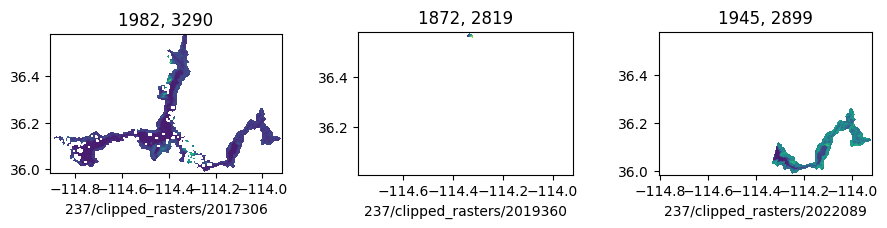

In [10]:
for res_idx in [237]:

    S30_x = []
    S30_y = []
    L30_x = []
    L30_y = []
    
    columns = ['file', 'sat', 's30_x', 's30_y', 'l30_x', 'l30_y']
    df = pd.DataFrame(columns=columns)

    
    folders = [os.path.join(str(res_idx),'clipped_rasters',d) for d in os.listdir(os.path.join(str(res_idx),'clipped_rasters'))]
    for f in tqdm(folders):
        sat = [s for s in os.listdir(f) if os.path.isdir(os.path.join(f,s))]
        try:
            for s in sat:
                if s=='S30':
                    ras_data = rio.open(os.path.join(f,s,'B04_stitched_raster.tif')).read(1).astype('float')
                    new_row = pd.DataFrame({
                        'file': f,
                        'sat': s,
                        's30_x': ras_data.shape[0],
                        's30_y': ras_data.shape[1],
                        'l30_x': np.nan,
                        'l30_y': np.nan,
                    }, index=[0])
                    df = pd.concat([df,new_row],ignore_index=True)
                if s=='L30':
                    ras_data = rio.open(os.path.join(f,s,'B04_stitched_raster.tif')).read(1).astype('float')
                    new_row = pd.DataFrame({
                        'file': f,
                        'sat': s,
                        'l30_x': ras_data.shape[0],
                        'l30_y': ras_data.shape[1],
                        's30_x': np.nan,
                        's30_y': np.nan,
                    }, index=[0])
                    df = pd.concat([df,new_row],ignore_index=True)
        except BaseException as error:
            print('An exception occurred: {}'.format(error))
    
    ## Sentinel raster sizes
    fig = plt.figure(figsize=(15, 10))
    k = 0
    for x in df['s30_x'].unique():
        for y in df['s30_y'].unique():
            df_ = df[(df['s30_x']==x)&(df['s30_y']==y)]
            if not df_.empty:
                ax = fig.add_subplot(6, 5, k + 1)
                ras = rio.open(os.path.join(df_.iloc[0,0],df_.iloc[0,1],'B04_stitched_raster.tif'))
                show(ras, ax=ax)
                ax.set_title('{}, {}'.format(x,y))
                ax.set_xlabel(df_.iloc[0,0])
                k = k + 1
    plt.tight_layout()
    plt.show()

    ## Landsat raster sizes
    fig = plt.figure(figsize=(15, 10))
    k = 0
    for x in df['l30_x'].unique():
        for y in df['l30_y'].unique():
            df_ = df[(df['l30_x']==x)&(df['l30_y']==y)]
            if not df_.empty:
                ax = fig.add_subplot(5, 5, k + 1)
                ras = rio.open(os.path.join(df_.iloc[0,0],df_.iloc[0,1],'B04_stitched_raster.tif'))
                show(ras, ax=ax)
                ax.set_title('{}, {}'.format(x,y))
                ax.set_xlabel(df_.iloc[0,0])
                k = k + 1
    plt.tight_layout()
    plt.show()

    df['pixel_area_l30'] = df['l30_x']*df['l30_y']
    df['pixel_area_s30'] = df['s30_x']*df['s30_y']

    df['pixel_area_l30'] = df['pixel_area_l30'].astype('float')
    df['pixel_area_s30'] = df['pixel_area_s30'].astype('float')

    if os.path.exists('max_img_extent.csv'):
        # Load the CSV file into the DataFrame
        extent_df = pd.read_csv('max_img_extent.csv')
    else:
        # Create an empty DataFrame with the specified columns
        columns = ['res_idx', 'L30_x', 'L30_y', 'S30_x', 'S30_y', 'l_file', 's_file']
        extent_df = pd.DataFrame(columns=columns)
    
    new_row = pd.DataFrame({
        'res_idx': res_idx, 
        'L30_x': df.loc[df['pixel_area_l30'].idxmax()]['l30_x'], 
        'L30_y': df.loc[df['pixel_area_l30'].idxmax()]['l30_y'], 
        'S30_x': df.loc[df['pixel_area_s30'].idxmax()]['s30_x'], 
        'S30_y': df.loc[df['pixel_area_s30'].idxmax()]['s30_y'], 
        'l_file': df.loc[df['pixel_area_l30'].idxmax()]['file'], 
        's_file': df.loc[df['pixel_area_s30'].idxmax()]['file']
    },index=[0])
    
    extent_df = pd.concat([extent_df, new_row], ignore_index=True)

    extent_df.to_csv('max_img_extent.csv', index=False)

## Pad smaller raster (test)

In [ ]:
def pad_raster(larger_raster_path, smaller_raster_path, padded_raster_path):
    """
    Pads the smaller raster to match the size of the larger raster.
    
    Parameters:
    - larger_raster_path: Path to the larger raster file.
    - smaller_raster_path: Path to the smaller raster file.
    - padded_raster_path: Path to save the padded raster.
    """
    
    with rio.open(larger_raster_path) as larger_raster:
        with rio.open(smaller_raster_path) as smaller_raster:
            
            # Extract pixel resolution from the raster's transform
            pixel_resolution_x = abs(smaller_raster.transform[0])
            pixel_resolution_y = abs(smaller_raster.transform[4])

            # Calculate the difference in extents
            left_diff = int((smaller_raster.bounds.left - larger_raster.bounds.left) / pixel_resolution_x)
            right_diff = int((larger_raster.bounds.right - smaller_raster.bounds.right) / pixel_resolution_x)
            top_diff = int((larger_raster.bounds.top - smaller_raster.bounds.top) / pixel_resolution_y)
            bottom_diff = int((smaller_raster.bounds.bottom - larger_raster.bounds.bottom) / pixel_resolution_y)
            
            # Read the smaller raster data
            smaller_data = smaller_raster.read(1)
            
            # Pad the smaller raster data
            padded_data = np.pad(smaller_data, ((top_diff, bottom_diff), (left_diff, right_diff)), 'constant', constant_values=-9999)
            
            # Create a new raster with the padded data and the same metadata as the larger raster
            with rio.open(padded_raster_path, 'w', **larger_raster.meta) as dst:
                dst.write(padded_data, 1)

In [ ]:
pad_raster('292/clipped_rasters/2019324/L30/B04_stitched_raster.tif', '292/clipped_rasters/2018065/L30/B04_stitched_raster.tif', 'test.tif')

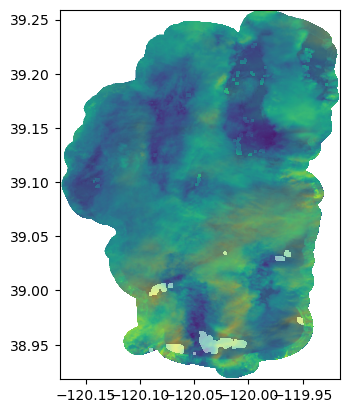

In [15]:
fig, ax = plt.subplots()
show(rio.open('test.tif'), ax = ax)
show(rio.open('292/clipped_rasters/2019324/L30/B04_stitched_raster.tif'), ax = ax, alpha=0.5)
plt.show()